#Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
import random
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.utils import shuffle

BASE_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/data/numpy data/'
BM_MODELS_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/models/BM/'
MC_MODELS_DIR = '/content/drive/Shareddrives/DeepLearningProject/Coccomini_Gholami_Zara/models/MC/'

PUBLIC_TEST_TENSOR = BASE_DIR + 'public_test_tensor.npy'
PUBLIC_TEST_LABELS = BASE_DIR + 'public_test_labels.npy'
PRIVATE_TEST_TENSOR = BASE_DIR + 'private_test_tensor.npy'

TRAIN_LABELS = BASE_DIR + 'train_labels.npy'
TRAIN_TENSOR = BASE_DIR + 'train_tensor.npy'

# training hyperparameters
TRAIN_EPOCHS = 50
BATCH_SIZE = 16
VERBOSE = 1
CLASS_WEIGHT = {0: 1., 1: 1.3}

RESCALE = 65535

process_manager = multiprocessing.Manager()

final_models_preds = {}
fine_tuned_models_preds = {}

In [ ]:
raw_train_data = np.load(TRAIN_TENSOR).reshape((5352, 150, 150, 1))
raw_train_labels = np.load(TRAIN_LABELS)
raw_test_data = np.load(PUBLIC_TEST_TENSOR).reshape((672, 150, 150, 1))
raw_test_labels = np.load(PUBLIC_TEST_LABELS)

# 0: baseline; 1-2: masses (b-m); 3-4: calcifications (b-m)

# Convert the dataset into a two-class one with only considering "benign" (0) and "malignant" (1).
def collapse_labels(labels):
  collapsed_labels = np.where((labels % 2) == 0, 1, 0)
  return collapsed_labels


# Datasets without baseline (no class 0)
train_data_no_baseline =  raw_train_data[1::2]
train_labels_no_baseline =  raw_train_labels[1::2]
test_data_no_baseline =  raw_test_data[1::2]
test_labels_no_baseline =  raw_test_labels[1::2]

#copy grayscale channel to channel 2 and 3 because pretrained models work with rgb images
train_data_no_baseline_RGB = np.concatenate((train_data_no_baseline[:], train_data_no_baseline[:], train_data_no_baseline[:]), axis=3);
test_data_no_baseline_RGB = np.concatenate((test_data_no_baseline[:], test_data_no_baseline[:], test_data_no_baseline[:]), axis=3);

# Collapse labels in mass and calcification classes
collapsed_train_labels = collapse_labels(train_labels_no_baseline)
collapsed_test_labels = collapse_labels(test_labels_no_baseline)


# Datasets only baseline (only class 0)
train_data_baseline =  raw_train_data[0::2]
train_labels_baseline =  raw_train_labels[0::2]
test_data_baseline =  raw_test_data[0::2]
test_labels_baseline =  raw_test_labels[0::2]

#copy grayscale channel to channel 2 and 3 because pretrained models work with rgb images
train_data_baseline_RGB = np.concatenate((train_data_baseline[:], train_data_baseline[:], train_data_baseline[:]), axis=3);
test_data_baseline_RGB = np.concatenate((test_data_baseline[:], test_data_baseline[:], test_data_baseline[:]), axis=3);


# no baseline data RGB
train_data_nb_RGB, val_data_nb_RGB, train_labels_nb_RGB, val_labels_nb_RGB = train_test_split(
                                                                    train_data_no_baseline_RGB,
                                                                    collapsed_train_labels,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )

#baseline data RGB
train_data_b_RGB, val_data_b_RGB, train_labels_b_RGB, val_labels_b_RGB = train_test_split(
                                                                    train_data_baseline_RGB,
                                                                    train_labels_baseline,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )
# no baseline data
train_data_nb, val_data_nb, train_labels_nb, val_labels_nb = train_test_split(
                                                                    train_data_no_baseline,
                                                                    collapsed_train_labels,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )

#baseline data
train_data_b, val_data_b, train_labels_b, val_labels_b = train_test_split(
                                                                    train_data_baseline,
                                                                    train_labels_baseline,
                                                                    train_size=0.8,
                                                                    random_state=42,
                                                                    shuffle=True
                                                              )


###Data Visualization

In [ ]:
def show_accuracy_loss_trends(fit_results):
  acc = fit_results['accuracy']
  val_acc = fit_results['val_accuracy']
  loss = fit_results['loss']
  val_loss = fit_results['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.ylim((0, 1))
  plt.plot(epochs, acc, 'g', label='Training acc')
  plt.plot(epochs, val_acc, 'g--', label='Validation acc')
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'r--', label='Validation loss')
  plt.legend()

  plt.show()

In [ ]:
def show_confusion_matrix(confusion_matrix):
  fig, ax = plt.subplots()
  im = ax.imshow(confusion_matrix, cmap="Blues")

  threshold = im.norm(confusion_matrix.max())/2.
  textcolors=("black", "white")

  ax.set_xticks(np.arange(2))
  ax.set_yticks(np.arange(2))
  ax.set_xticklabels(["benign", "malignant"])
  ax.set_yticklabels(["benign", "malignant"])
  
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

  for i in range(2):
      for j in range(2):
          text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", 
                         fontsize=12, color=textcolors[int(im.norm(confusion_matrix[i, j]) > threshold)])

  fig.tight_layout()
  plt.show()

In [ ]:
def show_roc_curves(models_preds):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for model, model_preds in models_preds.items():
    fpr,tpr,th = metrics.roc_curve(collapsed_test_labels,model_preds)
    model_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label= model + ' (area = {:.3f})'.format(model_auc))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

In [ ]:
def show_generator_images(generator):
  from tensorflow.keras.preprocessing import image

  i = 0
  var = np.asarray(next(generator))
  images = np.asarray(var[0])

  for baseline, abnormality in zip(images[0], images[1]):
      plt.figure(i)
      plt.subplot(121)
      plt.imshow(image.array_to_img(baseline))
      plt.subplot(122)
      plt.imshow(image.array_to_img(abnormality))
      i += 1

  plt.show()

###Data Augmentation

In [ ]:
# data augmentation hyperparameters
HORIZONTAL_FLIP = True
VERTICAL_FLIP = True
ROTATION_RANGE = 360
FILL_MODE='nearest'

def get_train_datagen(preprocess):
  from tensorflow import keras
  from keras.preprocessing.image import ImageDataGenerator
  return ImageDataGenerator(
        preprocessing_function=preprocess,
        horizontal_flip = HORIZONTAL_FLIP,
        vertical_flip = VERTICAL_FLIP, 
        rotation_range = ROTATION_RANGE,
        fill_mode=FILL_MODE
      )

def get_validation_datagen(preprocess):
  from tensorflow import keras
  from keras.preprocessing.image import ImageDataGenerator
  return ImageDataGenerator(
        preprocessing_function=preprocess
      )


def get_pretrained_train_generator(train_data, train_labels, preprocess):
  return get_train_datagen(preprocess).flow(train_data, train_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)

def get_pretrained_validation_generator(validation_data, validation_labels, preprocess):
  return get_validation_datagen(preprocess).flow(validation_data, validation_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)


def get_baseline_train_generator(baseline_data, baseline_labels, no_baseline_data, no_baseline_labels, preprocess):
  baseline_generator = get_train_datagen(preprocess).flow(baseline_data, baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)
  abnormality_generator = get_train_datagen(preprocess).flow(no_baseline_data, no_baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)

  while True:
          baseline = baseline_generator.next()
          abnormality = abnormality_generator.next()
          yield [baseline[0], abnormality[0]], abnormality[1]


def get_baseline_validation_generator(baseline_data, baseline_labels, no_baseline_data, no_baseline_labels, preprocess):
  baseline_generator = get_validation_datagen(preprocess).flow(baseline_data, baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)
  abnormality_generator = get_validation_datagen(preprocess).flow(no_baseline_data, no_baseline_labels, batch_size=BATCH_SIZE, shuffle=True, seed=42)

  while True:
          baseline = baseline_generator.next()
          abnormality = abnormality_generator.next()
          yield [baseline[0], abnormality[0]], abnormality[1]

#Adding Mass/Calcification information to the Benign/Malignant classification

##With baseline

###Model architecture

In [ ]:
def get_baseline_MC_BM_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.models import load_model
  from keras import regularizers
  from keras import Model


  bm_model = load_model(os.path.join(BM_MODELS_DIR,'baseline_resnet_tuned.h5'))
  bm_features_model = Model(inputs=bm_model.input, outputs=bm_model.get_layer('subtract').output)
  bm_features_model._name = "bm_features_model"
  bm_features_model.trainable = False

  mc_model = load_model(os.path.join(MC_MODELS_DIR,'baseline_vgg16_tuned.h5'))
  mc_model._name = "mc_model"
  mc_model.trainable = False

  baseline_input = keras.Input(shape=(150, 150, 3))
  abnormality_input = keras.Input(shape=(150, 150, 3))

  mc_prediction = mc_model([baseline_input, abnormality_input])
  bm_features = bm_features_model([baseline_input, abnormality_input])

  prediction_features_concatenation = layers.Concatenate()([mc_prediction, bm_features])
  dense_1 = layers.Dense(256,activation='sigmoid')(prediction_features_concatenation)
  prediction = layers.Dense(1,activation='sigmoid')(dense_1)

  # Connect the inputs with the outputs
  MC_BM_model = Model(inputs=[baseline_input, abnormality_input], outputs=prediction)


  ada = keras.optimizers.Adam(learning_rate=0.001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  # rms = keras.optimizers.RMSprop(lr=2e-6)
  MC_BM_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  #MC_BM_model.summary()
  return MC_BM_model

###Training and Evaluation

In [ ]:
def baseline_MC_BM_test(MC_BM_preds):
  if VERBOSE == 1: print("Testing")
  train_generator = get_baseline_train_generator(train_data_b_RGB, train_labels_b_RGB, train_data_nb_RGB, train_labels_nb_RGB, None)
  validation_generator = get_baseline_validation_generator(val_data_b_RGB, val_labels_b_RGB, val_data_nb_RGB, val_labels_nb_RGB, None)

  final_model = get_baseline_MC_BM_model()
  fit_results = final_model.fit(
      train_generator,
      epochs=TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      validation_data=validation_generator,
      validation_steps=int(np.ceil(len(train_data_b_RGB) / float(BATCH_SIZE))),
      class_weight=CLASS_WEIGHT,
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict([test_data_baseline_RGB, test_data_no_baseline_RGB])

  for pred in preds:
    MC_BM_preds.append(pred[0])
  
  final_model.save(os.path.join(BM_MODELS_DIR,'MC_BM_baseline.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 55s 352ms/step - loss: 0.7916 - accuracy: 0.5728 - val_loss: 0.6550 - val_accuracy: 0.6175
Epoch 2/50
134/134 [==============================] - 43s 324ms/step - loss: 0.7645 - accuracy: 0.6159 - val_loss: 0.6640 - val_accuracy: 0.6179
Epoch 3/50
134/134 [==============================] - 43s 322ms/step - loss: 0.7469 - accuracy: 0.6064 - val_loss: 0.6629 - val_accuracy: 0.6155
Epoch 4/50
134/134 [==============================] - 43s 323ms/step - loss: 0.7462 - accuracy: 0.6242 - val_loss: 0.6512 - val_accuracy: 0.6278
Epoch 5/50
134/134 [==============================] - 43s 322ms/step - loss: 0.7452 - accuracy: 0.6339 - val_loss: 0.6644 - val_accuracy: 0.5819
Epoch 6/50
134/134 [==============================] - 43s 323ms/step - loss: 0.7453 - accuracy: 0.6110 - val_loss: 0.6477 - val_accuracy: 0.6383
Epoch 7/50
134/134 [==============================] - 43s 322ms/step - loss: 0.7401 - accuracy: 0.6353 - val_loss: 0.6454 

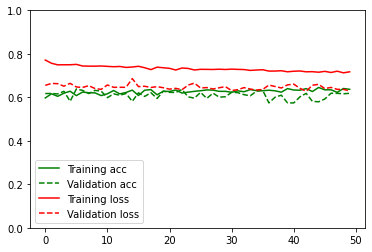

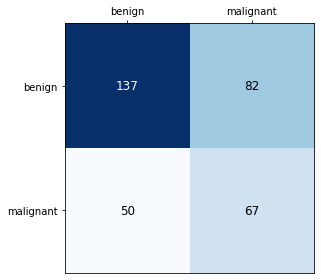


Baseline MC_BM test accuracy: 0.6071428571428571


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=baseline_MC_BM_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nBaseline MC_BM test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"mc_bm": preds})

##Only Abnormalities (v1)

###Model architecture

In [ ]:
def get_pretrained_MC_BM_v1_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.models import load_model
  from keras import regularizers
  from keras import Model


  bm_model = load_model(os.path.join(BM_MODELS_DIR,'pretrained_resnet_tuned.h5'))
  bm_features_model = Model(inputs=bm_model.input, outputs=bm_model.get_layer('flatten').output)
  bm_features_model._name = "bm_features_model"
  bm_features_model.trainable = False

  mc_model = load_model(os.path.join(MC_MODELS_DIR,'pretrained_vgg16_tuned.h5'))
  mc_model._name = "mc_model"
  mc_model.trainable = False

  abnormality_input = keras.Input(shape=(150, 150, 3))

  mc_prediction = mc_model(abnormality_input)
  bm_features = bm_features_model(abnormality_input)

  prediction_features_concatenation = layers.Concatenate()([mc_prediction, bm_features])
  dense_1 = layers.Dense(256,activation='sigmoid')(prediction_features_concatenation)
  prediction = layers.Dense(1,activation='sigmoid')(dense_1)

  # Connect the inputs with the outputs
  MC_BM_model = Model(inputs=abnormality_input, outputs=prediction)


  ada = keras.optimizers.Adam(learning_rate=0.0001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  #rms = keras.optimizers.RMSprop(lr=2e-6)
  MC_BM_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  #MC_BM_model.summary()
  return MC_BM_model

###Training and Evaluation

In [ ]:
def pretrained_MC_BM_v1_test(MC_BM_preds):
  if VERBOSE == 1: print("Testing")
  train_generator = get_pretrained_train_generator(train_data_nb_RGB, train_labels_nb_RGB, None)
  validation_generator = get_pretrained_validation_generator(val_data_nb_RGB, val_labels_nb_RGB, None)

  final_model = get_pretrained_MC_BM_v1_model()
  fit_results = final_model.fit(
      train_generator,
      epochs=TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_nb_RGB) / float(BATCH_SIZE))),
      validation_data=validation_generator,
      validation_steps=int(np.ceil(len(val_data_nb_RGB) / float(BATCH_SIZE))),
      class_weight=CLASS_WEIGHT,
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict(test_data_no_baseline_RGB)

  for pred in preds:
    MC_BM_preds.append(pred[0])
  
  final_model.save(os.path.join(BM_MODELS_DIR,'MC_BM_pretrained_v1.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 23s 129ms/step - loss: 1.2357 - accuracy: 0.5863 - val_loss: 0.9048 - val_accuracy: 0.5896
Epoch 2/50
134/134 [==============================] - 15s 113ms/step - loss: 1.0203 - accuracy: 0.5888 - val_loss: 0.7094 - val_accuracy: 0.5896
Epoch 3/50
134/134 [==============================] - 15s 112ms/step - loss: 0.8674 - accuracy: 0.5663 - val_loss: 0.6776 - val_accuracy: 0.5896
Epoch 4/50
134/134 [==============================] - 15s 111ms/step - loss: 0.7773 - accuracy: 0.5982 - val_loss: 0.6829 - val_accuracy: 0.5877
Epoch 5/50
134/134 [==============================] - 15s 111ms/step - loss: 0.7807 - accuracy: 0.5856 - val_loss: 0.6833 - val_accuracy: 0.5896
Epoch 6/50
134/134 [==============================] - 15s 112ms/step - loss: 0.7762 - accuracy: 0.5930 - val_loss: 0.6840 - val_accuracy: 0.5896
Epoch 7/50
134/134 [==============================] - 15s 112ms/step - loss: 0.7751 - accuracy: 0.6016 - val_loss: 0.6842 

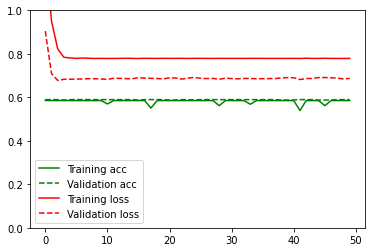

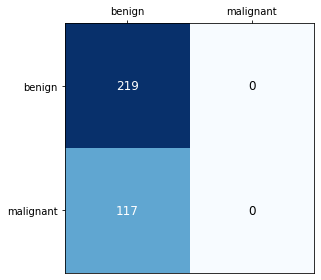


Pretrained MC_BM v1 test accuracy: 0.6517857142857143


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=pretrained_MC_BM_v1_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nPretrained MC_BM v1 test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"pretrained_mc_bm_v1": preds})

##Only Abnormalities (v2)

###Model architecture

In [ ]:
def get_pretrained_MC_BM_v2_model():
  from tensorflow import keras
  from keras import layers
  from keras import models
  from keras.models import load_model
  from keras import regularizers
  from keras import Model


  bm_model = load_model(os.path.join(BM_MODELS_DIR,'pretrained_resnet_tuned.h5'))
  bm_features_model = Model(inputs=bm_model.input, outputs=bm_model.get_layer('flatten').output)
  bm_features_model._name = "bm_features_model"
  bm_features_model.trainable = False

  mc_model = load_model(os.path.join(MC_MODELS_DIR,'pretrained_vgg16_tuned.h5'))
  mc_model._name = "mc_model"
  mc_model.trainable = False

  abnormality_input = keras.Input(shape=(150, 150, 3))

  mc_prediction = mc_model(abnormality_input)
  bm_features = bm_features_model(abnormality_input)

  dense_1 = layers.Dense(256,activation='sigmoid')(mc_prediction*bm_features)
  prediction = layers.Dense(1,activation='sigmoid')(dense_1)

  # Connect the inputs with the outputs
  MC_BM_model = Model(inputs=abnormality_input, outputs=prediction)


  ada = keras.optimizers.Adam(learning_rate=0.0001)
  # sgd = keras.optimizers.SGD(learning_rate=0.1)
  #rms = keras.optimizers.RMSprop(lr=2e-6)
  MC_BM_model.compile(loss="binary_crossentropy", optimizer=ada, metrics=['accuracy'])

  #MC_BM_model.summary()
  return MC_BM_model

###Training and Evaluation

In [ ]:
def pretrained_MC_BM_v2_test(MC_BM_preds):
  if VERBOSE == 1: print("Testing")
  train_generator = get_pretrained_train_generator(train_data_nb_RGB, train_labels_nb_RGB, None)
  validation_generator = get_pretrained_validation_generator(val_data_nb_RGB, val_labels_nb_RGB, None)

  final_model = get_pretrained_MC_BM_v2_model()
  fit_results = final_model.fit(
      train_generator,
      epochs=TRAIN_EPOCHS,
      steps_per_epoch=int(np.ceil(len(train_data_nb_RGB) / float(BATCH_SIZE))),
      validation_data=validation_generator,
      validation_steps=int(np.ceil(len(val_data_nb_RGB) / float(BATCH_SIZE))),
      class_weight=CLASS_WEIGHT,
      verbose=VERBOSE
  )
  
  show_accuracy_loss_trends(fit_results.history)

  preds = final_model.predict(test_data_no_baseline_RGB)

  for pred in preds:
    MC_BM_preds.append(pred[0])
  
  final_model.save(os.path.join(BM_MODELS_DIR,'MC_BM_pretrained_v2.h5'))

Testing
Epoch 1/50
134/134 [==============================] - 23s 130ms/step - loss: 1.3937 - accuracy: 0.5629 - val_loss: 0.7124 - val_accuracy: 0.4104
Epoch 2/50
134/134 [==============================] - 15s 113ms/step - loss: 0.7840 - accuracy: 0.4360 - val_loss: 0.6882 - val_accuracy: 0.5896
Epoch 3/50
134/134 [==============================] - 15s 113ms/step - loss: 0.7799 - accuracy: 0.5809 - val_loss: 0.6849 - val_accuracy: 0.5896
Epoch 4/50
134/134 [==============================] - 15s 112ms/step - loss: 0.7810 - accuracy: 0.5779 - val_loss: 0.6841 - val_accuracy: 0.5896
Epoch 5/50
134/134 [==============================] - 15s 112ms/step - loss: 0.7765 - accuracy: 0.5917 - val_loss: 0.6888 - val_accuracy: 0.5896
Epoch 6/50
134/134 [==============================] - 15s 112ms/step - loss: 0.7804 - accuracy: 0.5794 - val_loss: 0.6883 - val_accuracy: 0.5896
Epoch 7/50
134/134 [==============================] - 15s 112ms/step - loss: 0.7784 - accuracy: 0.5871 - val_loss: 0.6835 

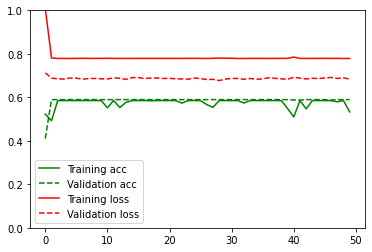

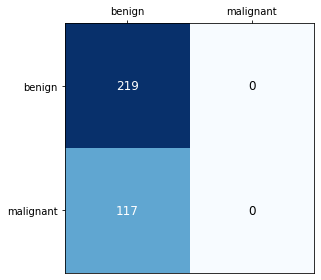


Pretrained MC_BM v2 test accuracy: 0.6517857142857143


In [ ]:
preds = process_manager.list()

#execute testing in a secondary process to avoid RAM saturation
p = multiprocessing.Process(target=pretrained_MC_BM_v2_test, args=(preds, ))
p.start()
p.join()

preds = np.asarray(preds)

show_confusion_matrix(metrics.confusion_matrix(collapsed_test_labels, np.rint(preds)))
print("\nPretrained MC_BM v2 test accuracy: " + str(metrics.accuracy_score(collapsed_test_labels, np.rint(preds))))

final_models_preds.update({"pretrained_mc_bm_v2": preds})